## Compare likelihoods for theories with massive neutrinos

We redo the notebook likelihood_test, but now varying also mnu. We will play with the different models in the paper on neutrinos: https://arxiv.org/abs/1911.09596

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our modules
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood
import likelihood_parameter
import lya_theory
import full_theory
import camb_cosmo
import CAMB_model
import linear_power_model

In [2]:
# specify verbosity for all objects (except emulator)
verbose=False

### Setup mock data, from one of simulations in the suite

In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,basedir=basedir,skewers_label=skewers_label,data_cov_factor=1)

### Setup archive of P1D measurements from simulations and train the emulator

In [4]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


### Setup relevant cosmology objects

In [6]:
# massless cosmology (to be used as fiducial)
cosmo_mnu0=camb_cosmo.get_cosmology(As=1.952e-9,mnu=0.0)
camb_cosmo.print_info(cosmo_mnu0)
# compute linP parameters
linP_mnu0=linear_power_model.LinearPowerModel(cosmo=cosmo_mnu0)
old_like_params_mnu0=linP_mnu0.get_likelihood_parameters()
print('old likelihood parameters')
for par in old_like_params_mnu0:
    print(par.info_str())
# setup camb model (needed in full_theory)
camb_model_mnu0=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_mnu0)
new_like_params_mnu0=camb_model_mnu0.get_likelihood_parameters()
print('new likelihood parameters')
for par in new_like_params_mnu0:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.9520E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
old likelihood parameters
g_star = 0.9677508579459803
f_star = 0.9813695511850136
Delta2_star = 0.33492276652520986
n_star = -2.2994794614403697
alpha_star = -0.21637599871410082
new likelihood parameters
ombh2 = 0.022
omch2 = 0.12
As = 1.952e-09
ns = 0.965
H0 = 67.0
mnu = 0.0


In [7]:
# massive cosmology (to be used as test)
cosmo_mnu03=camb_cosmo.get_cosmology(As=2.142e-9,mnu=0.3)
camb_cosmo.print_info(cosmo_mnu03)
# compute linP parameters
linP_mnu03=linear_power_model.LinearPowerModel(cosmo=cosmo_mnu03)
old_like_params_mnu03=linP_mnu03.get_likelihood_parameters()
print('old likelihood parameters')
for par in old_like_params_mnu03:
    print(par.info_str())
# setup camb model (needed in full_theory)
camb_model_mnu03=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_mnu03)
new_like_params_mnu03=camb_model_mnu03.get_likelihood_parameters()
print('new likelihood parameters')
for par in new_like_params_mnu03:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 3.2257E-03, A_s = 2.1420E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
old likelihood parameters
g_star = 0.9687130850033866
f_star = 0.9690024397615453
Delta2_star = 0.330053142432941
n_star = -2.302227090894706
alpha_star = -0.21455144240676077
new likelihood parameters
ombh2 = 0.022
omch2 = 0.12
As = 2.142e-09
ns = 0.965
H0 = 67.0
mnu = 0.3004409523855098


### Setup and compare theory objects for massless cosmology

Start by setting up an old theory object, that uses only compressed linP parameters

In [8]:
old_theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_mnu0,verbose=verbose)
old_emu_calls_mnu0=old_theory.get_emulator_calls()

Setup now a new theory object, that holds a CAMB object

In [9]:
new_theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_mnu0,verbose=verbose)
new_emu_calls_mnu0=new_theory.get_emulator_calls(return_M_of_z=False)

In [10]:
print("z=2 emulator calls for old theory = ", old_emu_calls_mnu0[0])
print("z=2 emulator calls for new theory = ", new_emu_calls_mnu0[0])

z=2 emulator calls for old theory =  {'Delta2_p': 0.5915230492673812, 'n_p': -2.302565037630148, 'alpha_p': -0.21497058768620103, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z=2 emulator calls for new theory =  {'Delta2_p': 0.5915230492673806, 'n_p': -2.3025650376301496, 'alpha_p': -0.2149705876861749, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}


Note that the numbers above are not supposed to exactly match, since kp_Mpc is slightly different in both theories

### Compare now emulator calls for the massive neutrino cosmology

In [11]:
# call the old theory, but using the freshly computed likelihood parameters from the test cosmology
old_emu_calls_mnu03=old_theory.get_emulator_calls(like_params=old_like_params_mnu03)

In [12]:
# we want to study also cases where we ignore some of the parameters
cull_params=['f_star','g_star','alpha_star']
culled_like_params_mnu03 = [par for par in old_like_params_mnu03 if par.name not in cull_params]
for par in culled_like_params_mnu03:
    print(par.info_str())
# same, but using only the culled parameters
culled_emu_calls_mnu03=old_theory.get_emulator_calls(like_params=culled_like_params_mnu03)

Delta2_star = 0.330053142432941
n_star = -2.302227090894706


In [13]:
# call the new theory, but using the freshly computed likelihood parameters for the test cosmology
new_emu_calls_mnu03=new_theory.get_emulator_calls(like_params=new_like_params_mnu03,return_M_of_z=False)

In [14]:
print("z = {} emulator calls from old theory = {}".format(data.z[0],old_emu_calls_mnu03[0]))
print("z = {} emulator calls from culled theory = {}".format(data.z[0],culled_emu_calls_mnu03[0]))
print("z = {} emulator calls from new theory = {}".format(data.z[0],new_emu_calls_mnu03[0]))

z = 2.0 emulator calls from old theory = {'Delta2_p': 0.5787667783988271, 'n_p': -2.3052865229771067, 'alpha_p': -0.2131460313788651, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13084042738901472, 'kF_Mpc': 9.230808629264576}
z = 2.0 emulator calls from culled theory = {'Delta2_p': 0.5828996245320662, 'n_p': -2.305312667084484, 'alpha_p': -0.21497058768619495, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z = 2.0 emulator calls from new theory = {'Delta2_p': 0.5745990158447655, 'n_p': -2.3031350839746256, 'alpha_p': -0.21398799346414799, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.12948756671119963, 'kF_Mpc': 9.327250305760211}


In [15]:
print("z = {} emulator calls from old theory = {}".format(data.z[-1],old_emu_calls_mnu03[-1]))
print("z = {} emulator calls from culled theory = {}".format(data.z[-1],culled_emu_calls_mnu03[-1]))
print("z = {} emulator calls from new theory = {}".format(data.z[-1],new_emu_calls_mnu03[-1]))

z = 4.0 emulator calls from old theory = {'Delta2_p': 0.21586774880220116, 'n_p': -2.3052870770974736, 'alpha_p': -0.21314640146655003, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124506575662015, 'kF_Mpc': 12.845338449227931}
z = 4.0 emulator calls from culled theory = {'Delta2_p': 0.21467955543264391, 'n_p': -2.3053132212048526, 'alpha_p': -0.21497095777387232, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}
z = 4.0 emulator calls from new theory = {'Delta2_p': 0.21428384783791596, 'n_p': -2.302932768034617, 'alpha_p': -0.21431523463323654, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.11127195468557453, 'kF_Mpc': 12.981409011442079}


Both new and old theories make the same emulator call for a theory that is not the fiducial!

## Test now the likelihood objects

### Old likelihood using all five parameters

In [16]:
## Set up a likelihood object with the old theory object
#old_free_params=['Delta2_star','n_star']
old_free_params=['Delta2_star','n_star','alpha_star','f_star','g_star']
old_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_parameters=old_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [17]:
# get parameter values in cube for test cosmology
old_values_mnu03=old_like.sampling_point_from_parameters(old_like_params_mnu03)
# check that parameters inferred from these are same than computed before
for par in old_like.parameters_from_sampling_point(values=old_values_mnu03):
    print(par.info_str(),',',par.value_in_cube())
old_like.get_log_like(values=old_values_mnu03,ignore_log_det_cov=False)

g_star = 0.9687130850033866 , 0.4678271250846657
f_star = 0.9690024397615453 , 0.47506099403863367
Delta2_star = 0.330053142432941 , 0.5336876162196065
n_star = -2.302227090894706 , 0.4777290910529426
alpha_star = -0.21455144240676077 , 0.5040777963021749


-623.1567096715809

### Old likelihood using only two parameters

In [18]:
## Set up a likelihood object with the old theory object, but now with only 2 key parameters
culled_free_params=['Delta2_star','n_star']
culled_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_parameters=culled_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [19]:
# get parameter values in cube for test cosmology
culled_values_mnu03=culled_like.sampling_point_from_parameters(culled_like_params_mnu03)
# check that parameters inferred from these are same than computed before
for par in culled_like.parameters_from_sampling_point(values=culled_values_mnu03):
    print(par.info_str(),',',par.value_in_cube())
culled_like.get_log_like(values=culled_values_mnu03,ignore_log_det_cov=False)

Delta2_star = 0.330053142432941 , 0.5336876162196065
n_star = -2.302227090894706 , 0.4777290910529426


-627.8719962397635

### New likelihood

In [20]:
## Set up a likelihood object with the new theory object
new_free_params=["As","ns","mnu"]
new_like=likelihood.Likelihood(data=data,theory=new_theory,
                            free_parameters=new_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [21]:
# get parameter values in cube for test cosmology in new theory
new_values_mnu03=new_like.sampling_point_from_parameters(new_like_params_mnu03)
# check that parameters inferred from these are same than computed before
for par in new_like.parameters_from_sampling_point(values=new_values_mnu03):
    print(par.info_str(),',',par.value_in_cube())

As = 2.142e-09 , 0.7099999999999995
ns = 0.965 , 0.5
mnu = 0.3004409523855098 , 0.3004409523855098


In [22]:
new_like.get_log_like(values=new_values_mnu03,ignore_log_det_cov=False)

-475.25790393044576

These results are not great... The chi2 are quite different, but the emulator calls seemed fine... Let me inspect.

### P1D predictions from the different theories

In [23]:
zs=data.z
k_kms=np.logspace(np.log10(min(data.k)),np.log10(max(data.k)),500)
old_p1d=old_like.get_p1d_kms(k_kms=k_kms,values=old_values_mnu03,return_covar=False)

In [24]:
culled_p1d=culled_like.get_p1d_kms(k_kms=k_kms,values=culled_values_mnu03,return_covar=False)

In [25]:
new_p1d=new_like.get_p1d_kms(k_kms=k_kms,values=new_values_mnu03,return_covar=False)

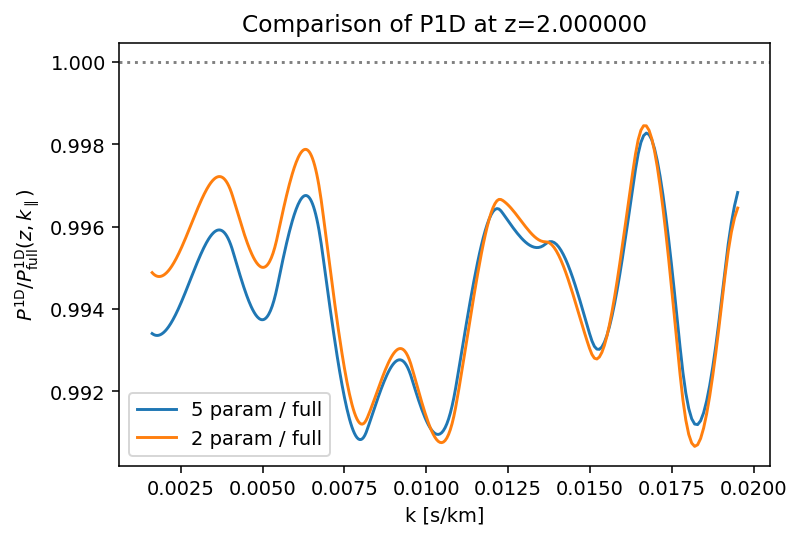

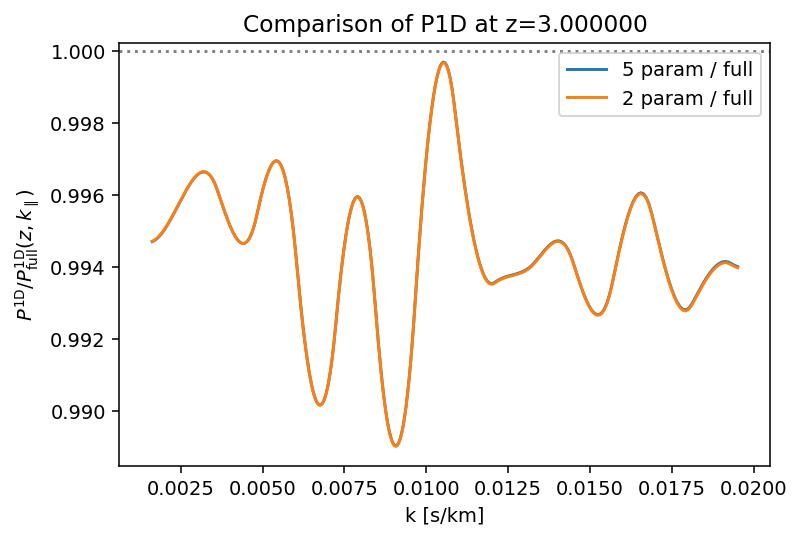

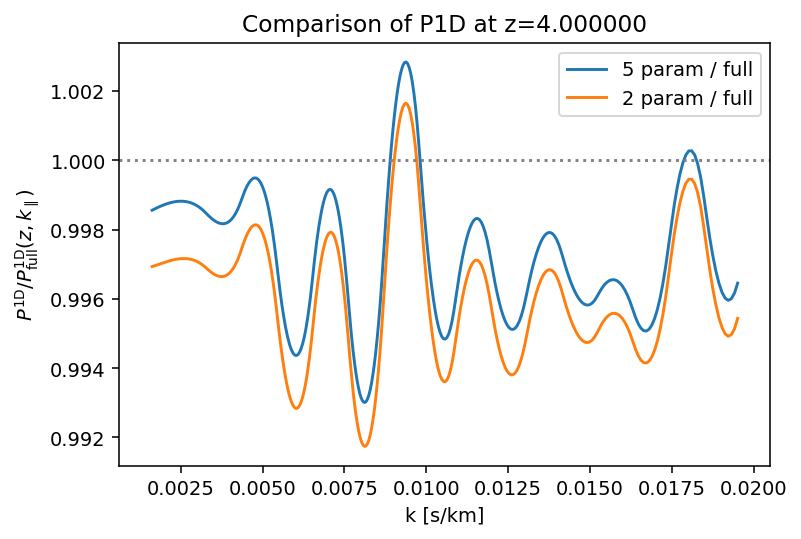

In [26]:
for iz in range(0,len(zs),4):
    z=zs[iz]
    plt.figure()
    plt.plot(k_kms,old_p1d[iz]/new_p1d[iz],label='5 param / full')
    plt.plot(k_kms,culled_p1d[iz]/new_p1d[iz],label='2 param / full')
    plt.legend()
    plt.xlabel('k [s/km]')
    plt.ylabel(r'$P^{\rm 1D} / P^{\rm 1D}_{\rm full} (z,k_\parallel)$')
    plt.xlim(min(k_kms)-0.001,max(k_kms)+0.001)
    plt.axhline(y=1,ls=':',color='gray')
    #plt.tight_layout()
    plt.title('Comparison of P1D at z=%f'%z)

I think these plots look pretty good!